# NextStrain Rabies metadata EDA

# Load libraries + data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
df = pd.read_table("../data/metadata.tsv")

In [3]:
df.columns

Index(['accession', 'accession_version', 'strain', 'date', 'region', 'country',
       'division', 'location', 'length', 'host', 'host_latin_name',
       'host_family', 'host_genus', 'host_group', 'host_common_name',
       'date_released', 'date_updated', 'sra_accessions', 'authors',
       'abbr_authors', 'institution'],
      dtype='object')

In [4]:
len(df)

32200

# Sampling dates

In [5]:
# Invalid parsing will be set as NaT
df["date_dt_parsed"] = pd.to_datetime(df["date"], errors="coerce")

/var/folders/1t/rb_zhnrn44550d9pg40ct1n00000gn/T/ipykernel_44107/2141689063.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date_dt_parsed"] = pd.to_datetime(df["date"], errors="coerce")


<Axes: xlabel='date_dt_parsed', ylabel='Count'>

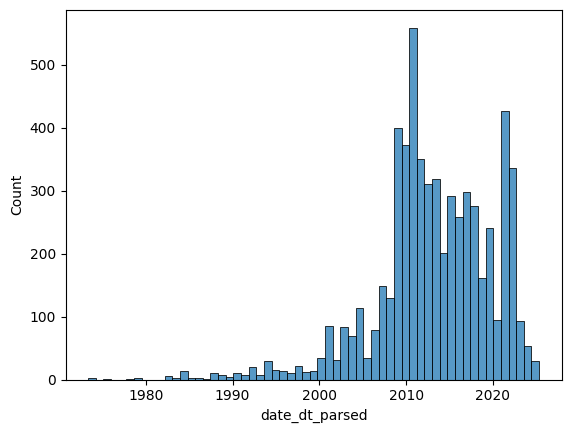

In [6]:
sns.histplot(data=df, x="date_dt_parsed")

**Did we lose data?**

In [7]:
print("Proportion of data with poorly entered dates:")
round(len(df[df["date_dt_parsed"].isna()]) / len(df), 3)

Proportion of data with poorly entered dates:


0.811

Answer: *YES*

## Dealing with bad dates

In [8]:
df["date"].value_counts().head()

date
XXXX-XX-XX    9767
2018-XX-XX     787
2008-XX-XX     748
2009-XX-XX     705
2006-XX-XX     652
Name: count, dtype: int64

In [9]:
print("Amount of incomplete dates:")
print(len(df[df["date"].str.contains("XX")]))
print("Amount of incomplete years:")
print(len(df[df["date"].str.contains("XXXX")]))

Amount of incomplete dates:
26099
Amount of incomplete years:
9767


## Manually years from date column

In [10]:
def get_year(date_str):
    if pd.isna(date_str):
        return pd.NA
    parts = str(date_str).split("-")
    if len(parts) == 3 and parts[0].isdigit():
        return int(parts[0])
    return pd.NA

In [11]:
df["year_parsed"] = df["date"].apply(get_year)

In [12]:
df["year_parsed"].value_counts().head(10)

year_parsed
2009    1435
2008    1189
2010    1113
2013    1091
2011    1083
2012    1083
2018    1050
2021     941
2014     885
2007     882
Name: count, dtype: int64

<Axes: xlabel='year_parsed', ylabel='Count'>

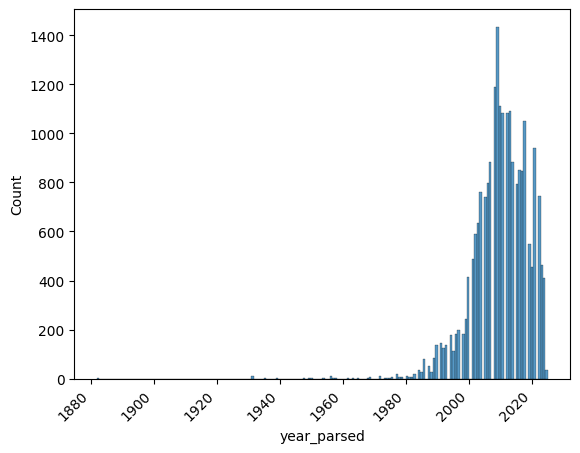

In [13]:
plt.xticks(rotation=45, ha="right")
sns.histplot(data=df, x="year_parsed")

Cutoff at year 2007

In [14]:
df_year_cutoff = df[df["year_parsed"] >= 2007]

<Axes: xlabel='year_parsed', ylabel='Count'>

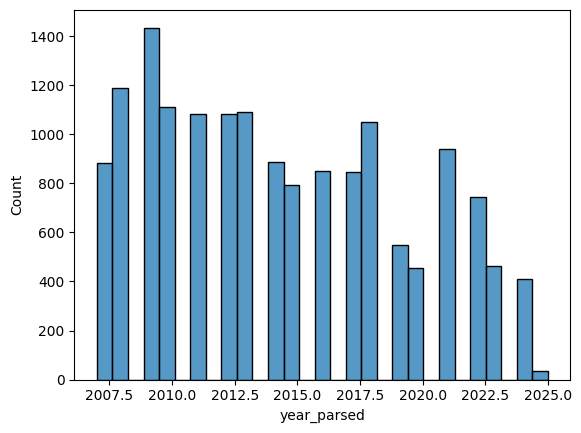

In [15]:
sns.histplot(data=df_year_cutoff, x="year_parsed")

# Stratifying by Host

## Host - year

In [16]:
crosstab_df = pd.crosstab(
    df_year_cutoff["host"], df_year_cutoff["year_parsed"], dropna=True
)
crosstab_df

year_parsed,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
host,,,,,,,,,,,,,,,,,,,
?,56,20,7,14,17,7,28,11,14,6,13,6,4,12,15,49,11,6,0
Bat,97,53,96,111,134,171,53,31,47,21,28,76,47,34,100,89,59,4,0
Bird,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Cattle,93,155,171,134,168,84,102,93,165,138,101,114,76,106,115,36,23,11,0
Domestic Dog,431,552,458,420,336,492,447,449,331,343,402,501,217,128,464,376,284,325,29
Fox (Vulpes sp.),48,103,168,188,75,69,75,44,31,20,30,29,26,18,28,43,4,2,0
Human,25,47,101,38,34,42,10,13,26,8,17,26,19,23,24,18,32,29,5
Other Carnivore,40,126,182,101,122,131,260,114,93,85,139,201,58,79,68,75,28,29,0
Other Mammal,2,10,0,3,4,3,3,21,2,3,6,4,16,2,23,11,2,0,0


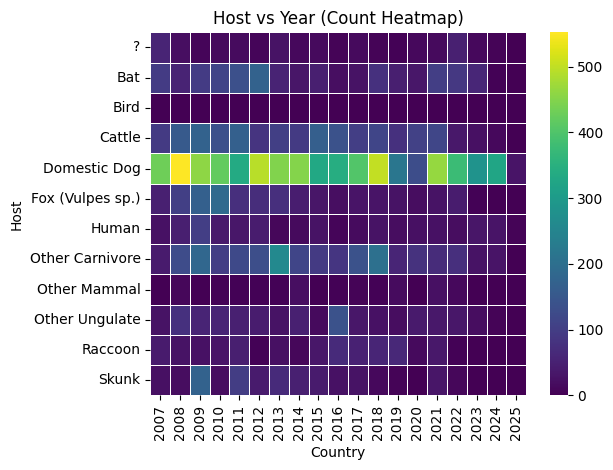

In [17]:
sns.heatmap(crosstab_df, cmap="viridis", linewidths=0.5)
plt.title("Host vs Year (Count Heatmap)")
plt.xlabel("Country")
plt.ylabel("Host")
plt.tight_layout()

## Host - Geographical

In [18]:
crosstab_df = pd.crosstab(df_year_cutoff["host"], df_year_cutoff["region"], dropna=True)
crosstab_df

region,Africa,Asia,Europe,North America,South America
host,,,,,
?,64,88,31,23,84
Bat,58,12,3,412,766
Bird,0,1,0,0,0
Cattle,318,414,200,48,903
Domestic Dog,2351,4100,262,91,163
Fox (Vulpes sp.),9,5,793,194,0
Human,38,462,7,12,18
Other Carnivore,515,658,428,261,65
Other Mammal,7,35,2,12,59


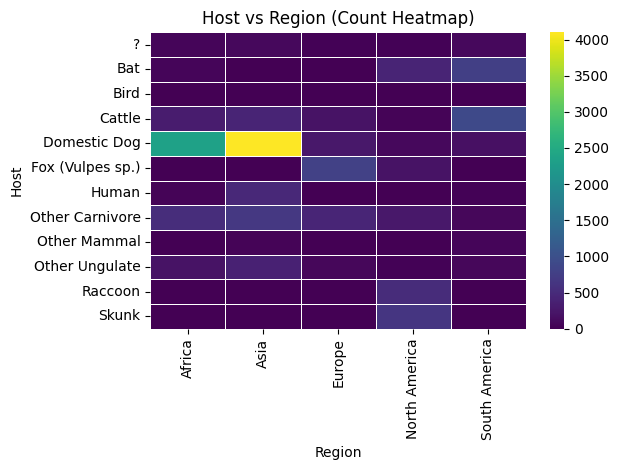

In [19]:
sns.heatmap(crosstab_df, cmap="viridis", linewidths=0.5)
plt.title("Host vs Region (Count Heatmap)")
plt.xlabel("Region")
plt.ylabel("Host")
plt.tight_layout()

# Rabies trivia

* Mode of transmission
    * As per [WHO](https://www.who.int/news-room/fact-sheets/detail/rabies), **dog bites and scratches** cause 99% of the human rabies cases, and can be prevented through dog vaccination and bite prevention.
* Negative strand RNA virus
* Entire genome comprised of 5 genes???
* NextStrain has combination of whole and incomplete genomes

# Research ideas

* Host switching
* Geography
* Mol. Evol. of Rabies virus

# Existing literature

**Most-cited**: Species-associations driving hy ecological factors, and epidemiological separation between reservoirs
* Mollentze, N., Biek, R. and Streicker, D.G. (2014) ‘The role of viral evolution in rabies host shifts and emergence’, Current Opinion in Virology, 8, pp. 68–72. Available at: https://doi.org/10.1016/j.coviro.2014.07.004.

**Very recent, high impact**: supplement relatedness (i.e. phylogenetic relatedness) with predictors such as temperature, temp. difference, litter size, weight, etc.
* Boutelle, C. et al. (2025) ‘A logistic regression model to predict the next rabies virus host-shift event’, Scientific Reports, 15(1), p. 19306. Available at: https://doi.org/10.1038/s41598-025-98986-x. 

**Bayesian inference on 1990's dataset, for sustained maintenance of Rabies in foxes**:
* Marston, D.A. et al. (2017) ‘Genetic analysis of a rabies virus host shift event reveals within-host viral dynamics in a new host’, Virus Evolution, 3(2). Available at: https://doi.org/10.1093/ve/vex038.


**Relevant recent (pre-print)**
* Ngoepe, C.E., Shumba, W. and Sabeta, C. (2024) ‘Evidence for a host switching in the maintenance of canid rabies variant in two wild carnivore species in the Northern Cape Province, South Africa’, Journal of the South African Veterinary Association [Preprint]. Available at: https://doi.org/10.36303/JSAVA.527.
> The rabies viruses recovered from the aardwolves between the year 2015 and 2017 were 100% nucleotide sequence identical, suggesting a single or common source and possible evidence for a host shift.
